# This model calculates Beta of the stock based on 5-year daily basis. 

Libraries

In [1]:
# Import the libraries
import pandas as pd
import pandas_datareader.data as reader
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from scipy import stats
import os

# Input: To Fill 

In [2]:
# Input the reference name from Yahoo Finance
a = "1295.KL"
b = "^KLSE%3B1%3D9"

# Type the effective date to calculate the Beta (based on last 5-years before the effective date)
# Date type: dd-mm-yyyy
effective_date = "31-12-2020"

Function

In [3]:
# Input based on the above 
input = [a,b]

Time

In [4]:
end = datetime.strptime(effective_date, "%d-%m-%Y")
start = end - relativedelta(years=5)

Dataframe

In [5]:
# We are using the "Adj close" price of the securities selected 
df = reader.get_data_yahoo(input, start, end)["Adj Close"]

In [6]:
# Print the dataframe
df

Symbols,1295.KL,^KLSE%3B1%3D9
Date,,
2015-12-31,3.120013,1692.510010
2016-01-04,3.079581,1653.369995
2016-01-05,3.086319,1665.699951
2016-01-06,3.089688,1667.969971
2016-01-07,3.089688,1655.130005
...,...,...
2020-12-24,3.991874,1641.170044
2020-12-28,4.034589,1643.900024
2020-12-29,4.019056,1634.989990


Calculation

In [7]:
# Calculate the daily returns 
day_ret = df.resample("D").ffill().pct_change()

# Remove the first row - NaN error 
day_ret = day_ret.dropna(axis=0)

# Print
day_ret

Symbols,1295.KL,^KLSE%3B1%3D9
Date,,
2016-01-01,0.000000,0.000000
2016-01-02,0.000000,0.000000
2016-01-03,0.000000,0.000000
2016-01-04,-0.012959,-0.023125
2016-01-05,0.002188,0.007457
...,...,...
2020-12-27,0.000000,0.000000
2020-12-28,0.010700,0.001663
2020-12-29,-0.003850,-0.005420


Define Variable

In [8]:
# Index selected above 
ind_pct = day_ret[b]

# Stock selected above 
stck_pct = day_ret[a]

Calculation

In [9]:
# Define the independence variable
ind_pct_sm = sm.add_constant(ind_pct)

In [10]:
# Define model by using ordinary least square approach 
model = sm.OLS (stck_pct, ind_pct_sm)
results = model.fit()

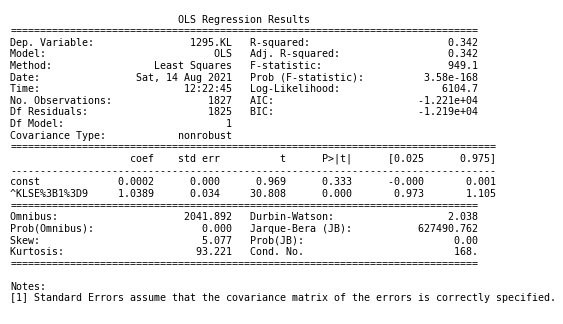

In [11]:
# coefficient of the index is the Beta figure
# p>t should be smaller than 0.05
plt.rc('figure', figsize=(7, 5))
plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png')

In [12]:
# Do the fit and print the slope (which is our beta value) to the screen.
slope, intercept, r, p, std_err  = stats.linregress(ind_pct,stck_pct)
print("Beta = ", slope)

Beta =  1.0389497726263504


Visualisation

In [13]:
# Create data needed to plot a the fit.  
# x starts and the min value of the Index data and goes to the max Index value
x = np.linspace(np.amin(ind_pct), np.amax(ind_pct))
y = slope * x + intercept

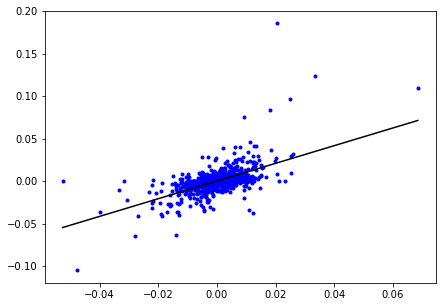

<ipython-input-14-b76c230e0cff>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig1.savefig(f"Beta_{a}_plot.png", dpi = 600, Transparent = True)


<Figure size 504x360 with 0 Axes>

In [14]:
# Plot it!
plt.plot(ind_pct, stck_pct, "b.")
plt.plot(x, y, "k")
plt.grid(False)
fig1 = plt.gcf()
plt.show()
plt.draw()

# Save the plot 
fig1.savefig(f"Beta_{a}_plot.png", dpi = 600, Transparent = True)

In [15]:
# Save the summary into CSV File
write_path = f"Beta_{a}.csv"
with open(write_path, 'w') as f:
    f.write (results.summary().as_csv())

In [16]:
# Read the CSV file 
df_new = pd.read_csv (f"Beta_{a}.csv", names = range(7))

In [17]:
# Save into Excel file 
writer = pd.ExcelWriter (f"Beta_{a}.xlsx", engine = "xlsxwriter")

df.to_excel (writer, sheet_name = "Original_data")
day_ret.to_excel (writer, sheet_name = "Daily_return")
df_new.to_excel (writer, sheet_name = "ANOVA", header = False, index = False)

# Include the plot into Excel file 
workbook = writer.book

worksheet = writer.sheets["Original_data"]
worksheet.hide_gridlines(2)

worksheet1 = writer.sheets["Daily_return"]
worksheet1.insert_image("E1",f"Beta_{a}_plot.png")
worksheet1.hide_gridlines(2)

worksheet2 = writer.sheets["ANOVA"]
worksheet2.insert_image("I1","output.png")
worksheet2.hide_gridlines(2)

writer.save()

In [18]:
#Remove unnecessary file 
os.remove(f"Beta_{a}.csv")
os.remove(f"Beta_{a}_plot.png")
os.remove ("output.png")